# Practical Machine Learning Assignment 2 Part B
Ryan Haggerty

The goal of this assignment is to solve regression and classification problems using the
following models on two types of data: numeric and text.
- Part A: Numeric Data - Regression Problem – Linear Regression using the
Stochastic Gradient Descent algorithm
- Part B: Natural Language Processing - Text Data - Classification Problem – KNearest Neighbors 

### Dataset
##### Description: 
CoAID (Covid-19 heAlthcare mIsinformation Dataset) is a diverse COVID-19 healthcare
misinformation dataset, including fake news on websites and social platforms, along with
users’ social engagement about such news. For this task, you will use the fake and true news articles that are collected from factchecked or reliable websites. The true/real and fake news articles are stored in two CSV files.

#### Source:
https://github.com/cuilimeng/CoAID

##### Input variables:
- type
- fact check url
- archive
- urls
- title
- content
- abstract
- publish date
- meta keywords
Only the input variable "content" will be used. 

##### Output variables: 
- label (authenticity)

The output is added as a binary value (1: real, 0: fake).


In [1]:
# Import python modules
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, cross_val_predict
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

C:\Users\ryguy\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryguy\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ryguy\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\ryguy\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ryguy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryguy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data & Displat Dataset Information

In [2]:
# Load data
df_real = pd.read_csv('/Users/ryguy/Documents/UNL/Classes/Practical Machine Learning/A02/Dataset-Assignment2/NewsRealCOVID-19-05.csv', header=0)
df_fake = pd.read_csv('/Users/ryguy/Documents/UNL/Classes/Practical Machine Learning/A02/Dataset-Assignment2/NewsFakeCOVID-19-05.csv', header=0)
df_real.head(5)

,Unnamed: 0,type,fact_check_url,news_url,title,newstitle,content,abstract,publish_date,meta_keywords
0,0,article,healthline.com,https://www.healthline.com/health-news/coronav...,Coronavirus Outbreak: Live Updates,"""Coronavirus Outbreak: Daily Updates""",experts warn most states that are reopening st...,the new coronavirus disease outbreak first ide...,NaN,"""coronavirus outbreak, viral outbreak, viral i..."
1,1,article,healthline.com,https://www.healthline.com/health-news/screen-...,"Screen Time Doesn’t Hurt Kids’ Social Skills, ...","""Screen Time Doesn't Hurt Kids' Social Skills,...",a new study finds an increase in screen time d...,new research found that school age children in...,NaN,"""screen time, child development, smartphones, ..."
2,2,article,healthline.com,https://www.healthline.com/health-news/heres-e...,Here’s Exactly Where We Are with Vaccines and ...,"""Where We're at with Vaccines and Treatments f...",scientists around the world are working on a n...,scientists around the world are working on a n...,NaN,"""covid-19 coronavirus outbreak research progre..."
3,3,article,healthline.com,https://www.healthline.com/health-news/heres-w...,Here’s What Happens to the Body After Contract...,"""Here's What Happens to the Body After Contrac...",coronaviruses cause respiratory illnesses so t...,heres what we know so far about how covid-19 a...,NaN,"""coronavirus, viral infection, viral outbreak,..."
4,4,article,healthline.com,https://www.healthline.com/health-news/why-you...,Why You Should Be Skeptical of Early Results o...,"""Why You Should Be Skeptical of Leaked Results...",medical experts are studying if remdesivir can...,with no approved treatment specific for covid-...,NaN,"""covid-19, covornavirus, novel coronavirus, vi..."


### Data Pre-processing


First we need to combine the two dataframes and extract only the information we need.

In [3]:
# Add new column titled "label" to each df
# 1 means the article is real, 0 means it is fake
df_real['label']=1
df_fake['label']=0

# Concatenate the two dataframes vertically
df_all=pd.concat([df_real, df_fake], ignore_index=True)

# Extract only the "content" and "label" columns
df_new=df_all[['content','label']]

### Exploratory Data Analysis

This section will perform basic EDA on the dataframe to be used for the experiments.

In [4]:
# Get information of the dataframe
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162 entries, 0 to 2161
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1522 non-null   object
 1   label    2162 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.9+ KB


In [5]:
# Check if there are any null values in any column
df_new.isna().values.any()

True

In [6]:
# Make a deep copy of the DataFrame object
df = df_new.copy()

# Remove the rows with missing values 
df = df.dropna(axis=0)

In [7]:
# Observe the dimension of the data
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (1522, 2)

No. of Rows: 1522
No. of Columns: 2


In [8]:
# Observe the class distribution
df.groupby('label').count()

,content
label,
0,125
1,1397


C:\Users\ryguy\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


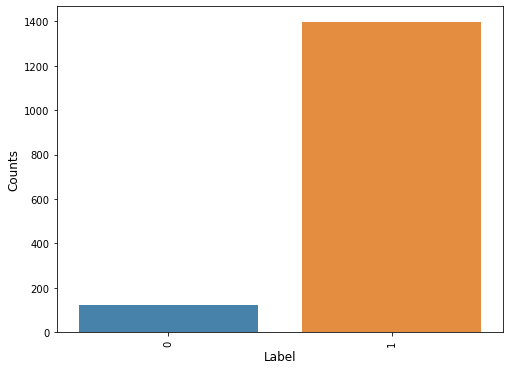

In [9]:
# Visualization of the class distribution
label_counts = df.label.value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha=0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.show()

As is evident from the distribution, there are many more real COVID-19 data points than fake

In [10]:
# Correlation between the content length and the label
# Create a new column "length" the stores the length of the text on each row
df['length'] = df['content'].map(lambda content: len(content))

df.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,125.0,441.048000,124.378251,36.0,488.0,492.0,494.0,500.0
1,1397.0,473.110236,73.065309,64.0,489.0,492.0,495.0,502.0


array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

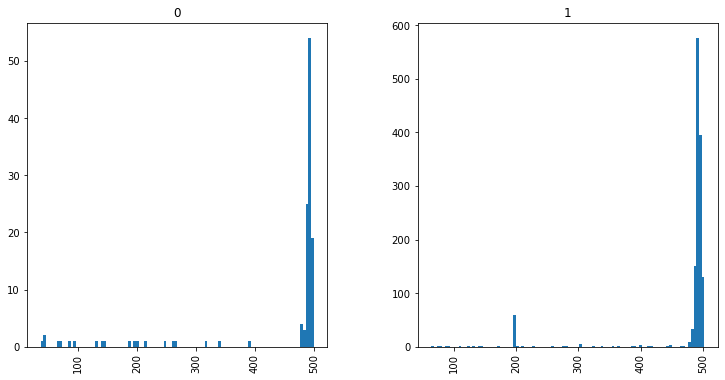

In [11]:
# Use a length threshold to visualize the distribution of length per class

threshold = 600
emails_subset = df[df.length < threshold]
emails_subset.hist(column='length', by='label', bins=100, figsize=(12, 6))

### Final Pre-Processing

In [12]:
%%time
# Text normalization by lemmatization
lemmatizer = WordNetLemmatizer()

df['content_lemmatized'] = df['content'].map(lambda content: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(content.lower())))

Wall time: 3.91 s


In [53]:
# Create separate feature set and target
X = df["content_lemmatized"] # Features
y = df['label'] # Target

#Convert X and y into numpy arrays
X = np.asarray(X)
y = np.asarray(y)

print("Data Matrix (X) Shape: ", X.shape)
print("Label array (y) Shape: ", y.shape)

print("\nData Matrix (X) Type: ", X.dtype)
print("Label array (y) Type: ", y.dtype)

Data Matrix (X) Shape:  (1522,)
Label array (y) Shape:  (1522,)

Data Matrix (X) Type:  object
Label array (y) Type:  int64


In [54]:
# Partition the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Finally, each text feature will need to be vectorized. There are three different vectorization techniques:
- binary features
- frequency of the features
- TF-IDF values
These vectorization techniques will be performed separately, once for each of the following experiments. The results of the experiments will be used to compare the vectorization techniques.

# Experiment 3

This experiment will use the binary features vectorization technique.

### Further Pre-Processing

In [32]:
# Create a CountVectorizer object with binary technique
count_vect = CountVectorizer(binary=True, stop_words='english') # uses binary counts for vectorization

'''
Using the CountVectorizer object, create a matrix representation of the training documents
Each row represents a single document
Each column represents the binary count for each feature
'''
X_train_count_vectorized_features = count_vect.fit_transform(X_train).todense()

print("\nCount Vectorized Training Data Matrix Dimension: ", X_train_count_vectorized_features.shape)
print("\nSize of Vocabulary: ", len(count_vect.vocabulary_))


# Using the CountVectorizer object, create a matrix representation of the test documents
X_test_count_vectorized_features = count_vect.transform(X_test).todense()
print("\nCount Vectorized Test Data Matrix Dimension: ", X_test_count_vectorized_features.shape)


# Convert the feature matrices into numpy ndarrays
X_train_count_vectorized_features = np.asarray(X_train_count_vectorized_features) 
X_test_count_vectorized_features = np.asarray(X_test_count_vectorized_features) 


Count Vectorized Training Data Matrix Dimension:  (1217, 7196)

Size of Vocabulary:  7196

Count Vectorized Test Data Matrix Dimension:  (305, 7196)


In [33]:
# Scale the features
scaler = StandardScaler()

# Fit on training set
scaler.fit(X_train_count_vectorized_features)

# Apply scaling to training and testing
X_train_count_vectorized_features3 = scaler.transform(X_train_count_vectorized_features)
X_test_count_vectorized_features3 = scaler.transform(X_test_count_vectorized_features)

### Model Training and Evaluation

In [29]:
%%time
# apply GridSearchCV using parameters ranges specified above

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,21,23,33,43], 'p': [1, 2, 3, 4, 5, 10, 100], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv_exp3 = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=10, verbose=3, n_jobs=-1)
knn_cv_exp3.fit(X_train_count_vectorized_features3, y_train)


params_optimal_knn_exp3 = knn_cv_exp3.best_params_

print("Best Score: %f" % knn_cv_exp3.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn_exp3)
print("\n")

Fitting 10 folds for each of 182 candidates, totalling 1820 fits
Best Score: 0.959526
Optimal Hyperparameter Values:  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


Wall time: 44min 12s


In [30]:
# Train Scikit-Learn’s KNeighborsClassifier model using the optimal hyperparameter values obtained from GridSearchCV
knnbest_exp3 = KNeighborsClassifier(**params_optimal_knn_exp3)

knnbest_exp3.fit(X_train_count_vectorized_features3, y_train)

y_train_predicted_exp3 = knnbest_exp3.predict(X_train_count_vectorized_features3)

train_accuracy_knn_exp3 = np.mean(y_train_predicted_exp3 == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn_exp3)

# Evaluate the model on the train data using the cross_val_score function and report the average accuracy.
scores_exp3 = cross_val_score(knnbest_exp3, X_train_count_vectorized_features3, y_train, scoring='accuracy', cv=5)

print("Accuracy Score: %0.3f (+/- %0.2f)" % (scores_exp3.mean(), scores_exp3.std() * 2))


Training Accuracy:  1.0
Accuracy Score: 0.923 (+/- 0.01)


In [58]:
#Test model
print("Test: Performance Measures Based on the Default Threshold (0.5):\n")

# Report test accuracy, test precision, test recall, test F1 score, and test confusion matrix
y_test_pred_exp3 = knnbest_exp3.predict(X_test_count_vectorized_features3)

test_accuracy_knn_exp3 = np.mean(y_test == y_test_pred_exp3)

print("Test Accuracy: ", test_accuracy_knn_exp3)

# Precision, Recall, F1 Score and Confusion Matrix for the Default Threshold 0.5
precision_test_exp3 = precision_score(y_test, y_test_pred_exp3) 
print("\nTest Precision = %f" % precision_test_exp3)

recall_test_exp3 = recall_score(y_test, y_test_pred_exp3)
print("Test Recall = %f" % recall_test_exp3)


f1_test_exp3 = f1_score(y_test, y_test_pred_exp3)
print("Test F1 Score = %f" % f1_test_exp3)

print("Test Confusion Matrix \n", confusion_matrix(y_test, y_test_pred_exp3))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_exp3, target_names = ["Fake", "Real"]))

Test: Performance Measures Based on the Default Threshold (0.5):

Test Accuracy:  0.940983606557377

Test Precision = 0.943144
Test Recall = 0.996466
Test F1 Score = 0.969072
Test Confusion Matrix 
 [[  5  17]
 [  1 282]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.83      0.23      0.36        22
        Real       0.94      1.00      0.97       283

    accuracy                           0.94       305
   macro avg       0.89      0.61      0.66       305
weighted avg       0.94      0.94      0.92       305



## Experiment 4

This experiment will use the frequency of the features vectorization technique.

### Further Pre-Processing

In [36]:
# Create a CountVectorizer object with frequency of the features technique
count_vect = CountVectorizer(stop_words='english') # uses frequency of the features for vectorization

X_train_count_vectorized_features = count_vect.fit_transform(X_train).todense()

print("\nCount Vectorized Training Data Matrix Dimension: ", X_train_count_vectorized_features.shape)
print("\nSize of Vocabulary: ", len(count_vect.vocabulary_))


# Using the CountVectorizer object, create a matrix representation of the test documents
X_test_count_vectorized_features = count_vect.transform(X_test).todense()
print("\nCount Vectorized Test Data Matrix Dimension: ", X_test_count_vectorized_features.shape)


# Convert the feature matrices into numpy ndarrays
X_train_count_vectorized_features = np.asarray(X_train_count_vectorized_features) 
X_test_count_vectorized_features = np.asarray(X_test_count_vectorized_features) 


Count Vectorized Training Data Matrix Dimension:  (1217, 7196)

Size of Vocabulary:  7196

Count Vectorized Test Data Matrix Dimension:  (305, 7196)


In [37]:
# Scale the features
scaler = StandardScaler()

# Fit on training set
scaler.fit(X_train_count_vectorized_features)

# Apply scaling to training and testing
X_train_count_vectorized_features4 = scaler.transform(X_train_count_vectorized_features)
X_test_count_vectorized_features4 = scaler.transform(X_test_count_vectorized_features)

### Model Training and Evaluation

In [38]:
%%time
# apply GridSearchCV using parameters ranges specified above

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,21,23,33,43], 'p': [1, 2, 3, 4, 5, 10, 100], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv_exp4 = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=10, verbose=3, n_jobs=-1)
knn_cv_exp4.fit(X_train_count_vectorized_features4, y_train)


params_optimal_knn_exp4 = knn_cv_exp4.best_params_

print("Best Score: %f" % knn_cv_exp4.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn_exp4)
print("\n")

Fitting 10 folds for each of 182 candidates, totalling 1820 fits
Best Score: 0.959526
Optimal Hyperparameter Values:  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


Wall time: 42min 38s


In [39]:
# Train Scikit-Learn’s KNeighborsClassifier model using the optimal hyperparameter values obtained from GridSearchCV
knnbest_exp4 = KNeighborsClassifier(**params_optimal_knn_exp4)

knnbest_exp4.fit(X_train_count_vectorized_features4, y_train)

y_train_predicted_exp4 = knnbest_exp4.predict(X_train_count_vectorized_features4)

train_accuracy_knn_exp4 = np.mean(y_train_predicted_exp4 == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn_exp4)

# Evaluate the model on the train data using the cross_val_score function and report the average accuracy.
scores_exp4 = cross_val_score(knnbest_exp4, X_train_count_vectorized_features4, y_train, scoring='accuracy', cv=5)

print("Accuracy Score: %0.3f (+/- %0.2f)" % (scores_exp4.mean(), scores_exp4.std() * 2))


Training Accuracy:  1.0
Accuracy Score: 0.923 (+/- 0.01)


In [60]:
#Test model
print("Test: Performance Measures Based on the Default Threshold (0.5):\n")

# Report test accuracy, test precision, test recall, test F1 score, and test confusion matrix
y_test_pred_exp4 = knnbest_exp4.predict(X_test_count_vectorized_features4)

test_accuracy_knn_exp4 = np.mean(y_test == y_test_pred_exp4)

print("Test Accuracy: ", test_accuracy_knn_exp4)

# Precision, Recall, F1 Score and Confusion Matrix for the Default Threshold 0.5
precision_test_exp4 = precision_score(y_test, y_test_pred_exp4) 
print("\nTest Precision = %f" % precision_test_exp4)

recall_test_exp4 = recall_score(y_test, y_test_pred_exp4)
print("Test Recall = %f" % recall_test_exp4)


f1_test_exp4 = f1_score(y_test, y_test_pred_exp4)
print("Test F1 Score = %f" % f1_test_exp4)

print("Test Confusion Matrix \n", confusion_matrix(y_test, y_test_pred_exp4))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_exp4, target_names = ["Fake", "Real"]))

Test: Performance Measures Based on the Default Threshold (0.5):

Test Accuracy:  0.940983606557377

Test Precision = 0.943144
Test Recall = 0.996466
Test F1 Score = 0.969072
Test Confusion Matrix 
 [[  5  17]
 [  1 282]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.83      0.23      0.36        22
        Real       0.94      1.00      0.97       283

    accuracy                           0.94       305
   macro avg       0.89      0.61      0.66       305
weighted avg       0.94      0.94      0.92       305



## Experiment 5

This experiment will use the term frequency–inverse document frequency (TF-IDF) vectorization technique.

### Further Pre-Processing

In [64]:
%%time

# Create a TF-IDF vectorizer object 
# The stop word removal attribute is activated (which can be removed if needed)
tfidf_vect = TfidfVectorizer(stop_words='english')


# Using the TfidfVectorizer object, create a matrix representation of the training documents
# Each row represents a single document
# Each column represents the binary count for each feature
X_train_tfidf_vectorized_features = tfidf_vect.fit_transform(X_train).todense()

print("\nCount Vectorized Training Data Matrix (TF-IDF) Dimension: ", X_train_tfidf_vectorized_features.shape)
print("\nSize of Vocabulary: ", len(tfidf_vect.vocabulary_))


# Using the CountVectorizer object, create a matrix representation of the test documents
X_test_tfidf_vectorized_features = tfidf_vect.transform(X_test).todense()
print("\nCount Vectorized Test Data Matrix (TF-IDF) Dimension: ", X_test_tfidf_vectorized_features.shape)


# Convert the feature matrices into numpy ndarrays
X_train_tfidf_vectorized_features = np.asarray(X_train_tfidf_vectorized_features) 
X_test_tfidf_vectorized_features = np.asarray(X_test_tfidf_vectorized_features)


Count Vectorized Training Data Matrix (TF-IDF) Dimension:  (1217, 7196)

Size of Vocabulary:  7196

Count Vectorized Test Data Matrix (TF-IDF) Dimension:  (305, 7196)
Wall time: 161 ms


### Model Training and Evaluation

In [65]:
%%time
# apply GridSearchCV using parameters ranges specified above

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17, 23,33,43], 'p': [1, 2, 3, 5, 10, 100], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv_exp5 = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_cv_exp5.fit(X_train_tfidf_vectorized_features, y_train)


params_optimal_knn_exp5 = knn_cv_exp5.best_params_

print("Best Score: %f" % knn_cv_exp5.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn_exp5)
print("\n")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Score: 0.967020
Optimal Hyperparameter Values:  {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


Wall time: 27min


In [66]:
# Train Scikit-Learn’s KNeighborsClassifier model using the optimal hyperparameter values obtained from GridSearchCV
knnbest_exp5 = KNeighborsClassifier(**params_optimal_knn_exp5)

knnbest_exp5.fit(X_train_tfidf_vectorized_features, y_train)

y_train_predicted_exp5 = knnbest_exp5.predict(X_train_tfidf_vectorized_features)

train_accuracy_knn_exp5 = np.mean(y_train_predicted_exp5 == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn_exp5)

# Evaluate the model on the train data using the cross_val_score function and report the average accuracy.
scores_exp5 = cross_val_score(knnbest_exp5, X_train_tfidf_vectorized_features, y_train, scoring='accuracy', cv=5)

print("Accuracy Score: %0.3f (+/- %0.2f)" % (scores_exp5.mean(), scores_exp5.std() * 2))


Training Accuracy:  1.0
Accuracy Score: 0.938 (+/- 0.01)


In [67]:
#Test model
print("Test: Performance Measures Based on the Default Threshold (0.5):\n")

# Report test accuracy, test precision, test recall, test F1 score, and test confusion matrix
y_test_pred_exp5 = knnbest_exp5.predict(X_test_tfidf_vectorized_features)

test_accuracy_knn_exp5 = np.mean(y_test == y_test_pred_exp5)

print("Test Accuracy: ", test_accuracy_knn_exp5)

# Precision, Recall, F1 Score and Confusion Matrix for the Default Threshold 0.5
precision_test_exp5 = precision_score(y_test, y_test_pred_exp5) 
print("\nTest Precision = %f" % precision_test_exp5)

recall_test_exp5 = recall_score(y_test, y_test_pred_exp5)
print("Test Recall = %f" % recall_test_exp5)


f1_test_exp5 = f1_score(y_test, y_test_pred_exp5)
print("Test F1 Score = %f" % f1_test_exp5)

print("Test Confusion Matrix \n", confusion_matrix(y_test, y_test_pred_exp5))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_exp5, target_names = ["Fake", "Real"]))

Test: Performance Measures Based on the Default Threshold (0.5):

Test Accuracy:  0.9606557377049181

Test Precision = 0.972125
Test Recall = 0.985866
Test F1 Score = 0.978947
Test Confusion Matrix 
 [[ 14   8]
 [  4 279]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.78      0.64      0.70        22
        Real       0.97      0.99      0.98       283

    accuracy                           0.96       305
   macro avg       0.87      0.81      0.84       305
weighted avg       0.96      0.96      0.96       305



## Experiment 6

The best performing experiment was Experiment 5. We will compute the precision-recall curve, adjust the threshold, and report the performance of that model in this experiment.

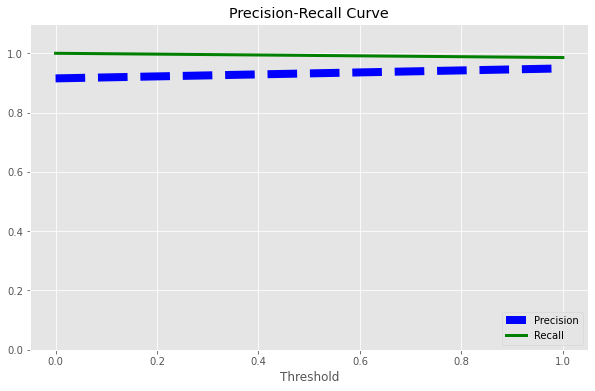

Optimal Threshold:  -1


In [55]:
# Get the 2nd column of the matrix of predicted probabilities for each data point
y_scores_exp6 = cross_val_predict(knnbest_exp5, X_train_tfidf_vectorized_features, y_train, method="predict_proba", cv=10)[:, 1]

# Generate the precision-recall curve for the model of Experiment 5
plt.style.use('ggplot')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_exp6)

fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--",  linewidth=8, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# Find and report the optimal threshold
threshold_optimal = -1
for i in range(len(precisions)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("Optimal Threshold: ", threshold_optimal)

We want to find a threshold that increases the recall for the misinformation class without decreasing precision too much. Here, smaller thresholds achieve this. If our goal was overall accuracy, it's clear that a higher threshold would be best for this model. However, since our goal is increased recall, we lower the threshold to 0.2.

In [63]:
print("Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):")

# Precision, Recall, F1 Score and Confusion Matrix for the optimal threshold

# Selected threshold from precision-recall curve 
t = 0.2

# Compute predictions based on new t by using the following method:
#  - Get the probability of the positive class from the 2nd column [:, 1]
#  - If that probability is greater than or equal to t, then the test data belongs to the positive class
y_train_predicted_new = (cross_val_predict(knnbest_exp5, X_train_tfidf_vectorized_features, y_train, method="predict_proba", cv=10)[:,1] > t).astype(int)

# Find training accuracy
train_accuracy_knn_exp6 = np.mean(y_train == y_train_predicted_new)

print("Train Accuracy: ", train_accuracy_knn_exp6)

# Find testing performance measures
y_test_predicted_new = (knnbest_exp5.predict_proba(X_test_tfidf_vectorized_features)[:,1] > t).astype(int)

test_accuracy_knn = np.mean(y_test == y_test_predicted_new)

print("\nTest Accuracy: ", test_accuracy_knn)


precision = precision_score(y_test, y_test_predicted_new) 
print("\nPrecision (Threshold %.2f) = %f" % (t, precision))

recall = recall_score(y_test, y_test_predicted_new)
print("Recall (Threshold %.2f) = %f" % (t, recall))


f1 = f1_score(y_test, y_test_predicted_new)
print("F1 Score = (Threshold %.2f) = %f" % (t, f1))

print("Confusion Matrix (Threshold %.2f)" %  t) 
print(confusion_matrix(y_test, y_test_predicted_new))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted_new, target_names = ["Fake", "Real"]))

Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):
Train Accuracy:  0.9383730484798686

Test Accuracy:  0.9606557377049181

Precision (Threshold 0.20) = 0.972125
Recall (Threshold 0.20) = 0.985866
F1 Score = (Threshold 0.20) = 0.978947
Confusion Matrix (Threshold 0.20)
[[ 14   8]
 [  4 279]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.78      0.64      0.70        22
        Real       0.97      0.99      0.98       283

    accuracy                           0.96       305
   macro avg       0.87      0.81      0.84       305
weighted avg       0.96      0.96      0.96       305

